### Examine the Data

In [121]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import pickle
import statsmodels.api as sm

In [122]:

# Read the dataset

# df_raw = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_raw = pd.read_csv('stuckat1_training.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [123]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [124]:
len(df_raw)

20001

### Plot the source data

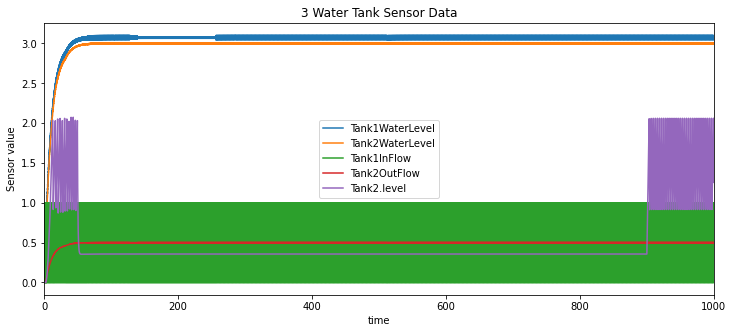

In [125]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)
# df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [126]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [127]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [128]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [129]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
#     return pd.DataFrame(normalised_data), means, stds
    return pd.DataFrame(normalised_data), means, stds


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data, means, stds = normalise_timeseries(df_raw)



In [130]:
# norm_vars = pd.concat([means, stds], axis=1)
# norm_vars

In [131]:
# norm_vars.to_csv(file_path)

### Save the mean and standard deviations globally or on disk

In [132]:
### METHOD ONE: USE %STORE MAGIC COMMAND
stored_norm_vars = pd.concat([means, stds], axis=1) # Stored Normalisation variables
%store stored_norm_vars

### METHOD TWO: SAVE AS A FILE
file_path = 'norm_var.csv'
norm_vars = pd.concat([means, stds], axis=1)
norm_vars.to_csv(file_path)

print(f'Normalisation variables saved successfully to {file_path}')

Stored 'stored_norm_vars' (DataFrame)
Normalisation variables saved successfully to norm_var.csv


#### Below cell has been modified

In [133]:
# df = normalised_data
df = df_raw

In [134]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.000000,0,0.000000,0.000000
0.05,6.890000e-07,3.110000e-07,0,0.000000,0,0.000000,0.000000
0.10,3.333928e-03,4.050000e-07,1,0.000000,0,0.000000,0.000000
0.15,5.448433e-02,8.850002e-03,1,0.000000,0,0.000000,0.000000
0.20,7.717051e-02,2.949715e-02,0,0.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...
999.80,3.078778e+00,2.994546e+00,1,0.498971,1,2.168533,1.547373
999.85,3.095068e+00,2.998294e+00,1,0.499269,1,2.077523,1.482432
999.90,3.081061e+00,3.005633e+00,0,0.500793,1,1.950239,1.391608


In [135]:
# Train Test Split
# nobs = 3000
nobs = 10000
# train = df[:-nobs]
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(10001, 10000)

### VAR Model Order Selection

In [136]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model_order = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model_order.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 38 has the least AIC value. Let us select p = 38 in the modelling


In [137]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -67.58148715086266
BIC: -67.54110924477959

VAR Order 2
AIC: -74.27192989574019
BIC: -74.1962148003774

VAR Order 3
AIC: -77.19502130959853
BIC: -77.08396293650353

VAR Order 4
AIC: -80.08132160516357
BIC: -79.93491386420385

VAR Order 5
AIC: -81.56080779491998
BIC: -81.37904459428248

VAR Order 6
AIC: -82.66264417796063
BIC: -82.445519424151

VAR Order 7
AIC: -83.558321718064
BIC: -83.30582931590605

VAR Order 8
AIC: -83.8888463802056
BIC: -83.60098023284066

VAR Order 9
AIC: -84.37154773934091
BIC: -84.04830174822713

VAR Order 10
AIC: -85.94790221271187
BIC: -85.58927027762365

VAR Order 11
AIC: -86.36784035550401
BIC: -85.97381637453135

VAR Order 12
AIC: -87.22679004680437
BIC: -86.7973679163522

VAR Order 13
AIC: -87.53601448691983
BIC: -87.07118810170742

VAR Order 14
AIC: -88.21532999001471
BIC: -87.71509324307503

VAR Order 15
AIC: -88.39990974626375
BIC: -87.8642565289428

VAR Order 16
AIC: -88.58410575446433
BIC: -88.01302995642054

VAR Order 17
AIC: -89.037

In [138]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [139]:
min_aic_index

19

In [140]:
min_aic_index = 50

In [141]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jul, 2023
Time:                     18:04:19
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -94.2531
Nobs:                     9951.00    HQIC:                  -95.4298
Log likelihood:           381426.    FPE:                1.96714e-42
AIC:                     -96.0322    Det(Omega_mle):     1.54331e-42
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -5.862931         0.152448          -38.459           0.000
L1.Tank1WaterLevel          0.153430         0.013049           11.758           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [142]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

50

In [143]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [144]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values, steps=steps)
z

array([[ 3.06262155e+00,  3.00403771e+00, -4.69672833e-04,
         5.00995101e-01,  1.00007705e+00,  4.99197924e-01,
         3.56799059e-01],
       [ 3.05744049e+00,  2.99586098e+00,  9.97804539e-01,
         4.99700915e-01,  9.98568279e-01,  4.99888818e-01,
         3.56873111e-01],
       [ 3.07876026e+00,  2.99454338e+00,  9.99769086e-01,
         4.98970417e-01,  9.98959517e-01,  4.98211136e-01,
         3.56942233e-01],
       [ 3.10203245e+00,  3.00129809e+00,  9.99783002e-01,
         4.99714852e-01,  9.99019396e-01,  4.98482914e-01,
         3.56962059e-01],
       [ 3.08107509e+00,  3.00563121e+00,  3.57163283e-04,
         5.00792402e-01,  9.97575622e-01,  4.96706693e-01,
         3.57092858e-01],
       [ 3.05496428e+00,  3.00170568e+00,  9.63830669e-04,
         5.00730074e-01,  9.96318585e-01,  4.94193296e-01,
         3.57424342e-01],
       [ 3.05745559e+00,  2.99585296e+00,  1.00003019e+00,
         4.99700001e-01,  9.96753918e-01,  4.92526328e-01,
         3.5781907

In [145]:
len(z)

20

In [146]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
500.05,3.062618,3.004038,0,0.500995,1,0.499978,0.356763
500.10,3.057439,2.995855,1,0.499700,1,0.500059,0.356821
500.15,3.078778,2.994546,1,0.498971,1,0.500045,0.356811
500.20,3.102069,3.001303,1,0.499715,1,0.499962,0.356752
500.25,3.081061,3.005633,0,0.500793,1,0.499945,0.356740
...,...,...,...,...,...,...,...
999.80,3.078778,2.994546,1,0.498971,1,2.168533,1.547373
999.85,3.095068,2.998294,1,0.499269,1,2.077523,1.482432
999.90,3.081061,3.005633,0,0.500793,1,1.950239,1.391608


In [147]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,3.062622,3.004038,-0.000470,0.500995,1.000077,0.499198,0.356799
1,3.057440,2.995861,0.997805,0.499701,0.998568,0.499889,0.356873
2,3.078760,2.994543,0.999769,0.498970,0.998960,0.498211,0.356942
3,3.102032,3.001298,0.999783,0.499715,0.999019,0.498483,0.356962
4,3.081075,3.005631,0.000357,0.500792,0.997576,0.496707,0.357093


### Plot the results

In [148]:
len(train.iloc[-30:,:])

30

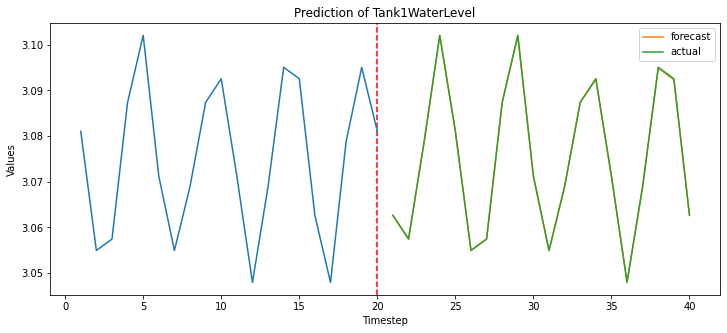

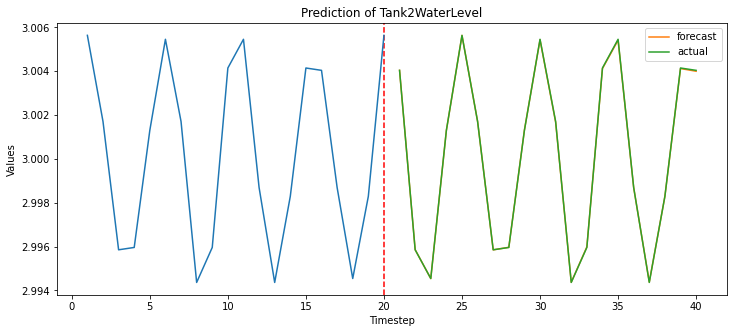

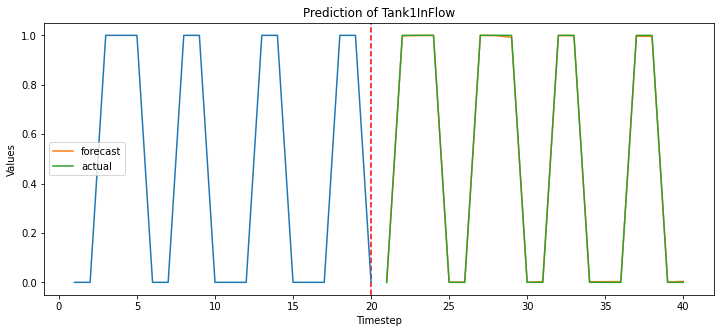

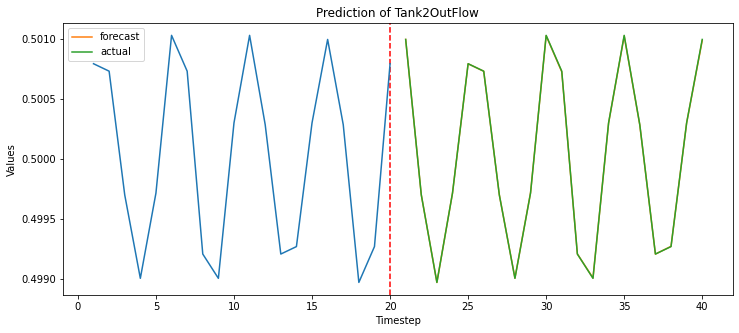

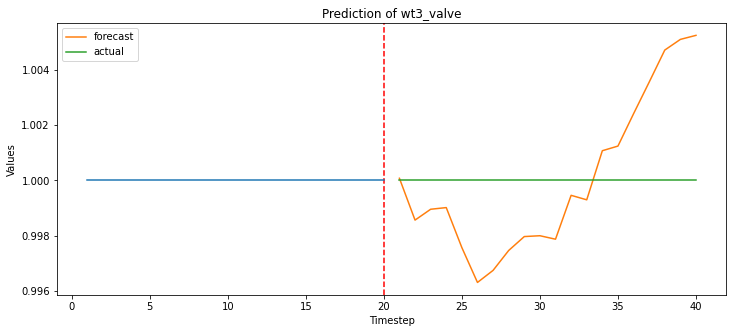

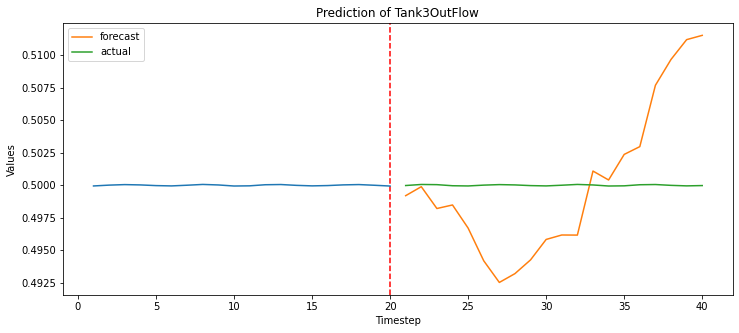

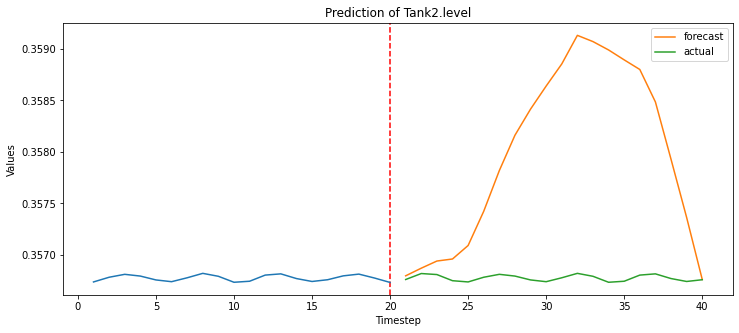

In [149]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [150]:
print("Temporary stop")
print(error)

Temporary stop


NameError: name 'error' is not defined

### Model Evaluation

In [ ]:
results.plot();

In [ ]:
results.plot_forecast(20);

In [ ]:
len(df_forecast)

### Model Evaluation (Quantitative)

In [ ]:
# ### RUBBISH
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# RMSE = []
# for feat in attr:
#     RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

# print(RMSE)

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

In [ ]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)

RMSEme = []
for feat in attr:
    RMSEme.append(root_mse(pred[feat], actual_test[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSEme)

### Save the model

In [ ]:
# # Serialize andsave the model
# import pickle
# import statsmodels.api as sm
# with open('var_golden_model.pkl', 'wb') as f:
#     pickle.dump(results.params, f)
# print("Model saved!")

with open('var_golden_model.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")


### Define the faulty data
##### We need to define a different normalisation function that will use the previous values of means and stds.

In [ ]:
# # Retrieve the saved and stored means and stds
# %store -r stored_norm_var
# old_means = stored_norm_var[0]
# old_stds = stored_norm_var[1]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



In [ ]:
# old_means, old_stds

In [ ]:
import pandas as pd
var_df = pd.read_csv("norm_var.csv", index_col=0)
var_df

In [ ]:
old_means, old_stds = var_df["0"], var_df["1"]

In [ ]:
# faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_df = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)
faulty_df.index.freq = 'MS'
num_obs = 3000

# normalised_data, means, stds = normalise_timeseries(faulty_data)
normalised_data = normalise_series(faulty_df, old_means, old_stds)
faulty_data = normalised_data

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

In [ ]:
faulty_data

### Load the model and reconstruct VAR

In [ ]:
with open('var_golden_model.pkl', 'rb') as f:
    params = pickle.load(f)
    
golden_model = sm.tsa.VAR(train)
golden_model.params = params
golden_model_fit = golden_model.fit(min_aic_index)
# golden_model_fit = golden_model.fit()
golden_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = golden_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
test_faulty

In [ ]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
# fault_forecast = pd.DataFrame(forecast, columns=attr)
# input_length = 20
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index_f = pd.Index(list(range(lag_order)))
#     actual_f = train_faulty.iloc[-lag_order:,:]
    
#     index_f = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual_f = actual_f.set_index(actual_index_f)
#     pred_f = fault_forecast.set_index(index_f)
#     actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual_f.iloc[:,i])
#     plt.plot(pred_f.iloc[:,i], label="forecast")
#     plt.plot(actual_test_f.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()


attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast, columns=attr)
input_length = 20
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(1,input_length+1)))
    actual_f = train_faulty.iloc[-input_length:,:]
    
    index_f = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:input_length,:].set_index(index_f)
    # draw a vertical line at x=20
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(pred_f[feat], actual_test_f[feat]))

print(RMSEf)



Evaluation of the model's performance can be done using the following:
- Accuracy
- Precision
- Recall
- F1 score

In [ ]:
print("I want to stop the execution of the notebook here")
print(error)

### Increasing the duration of faults

In [ ]:
df_test_extend = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_test_extend.index.freq = 'MS'
faulty_data_extend = normalise_timeseries(df_test_extend)

# faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# normalised_data_extend, means, stds = normalise_timeseries(faulty_data_extend)
# faulty_data_extend = normalised_data_extend
faulty_data_extend = df_test_extend

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = golden_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast_extend, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Fault Detection

In [ ]:
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# ndf = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
ndf = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0)
ndf.plot(figsize=(16,6))

In [ ]:
# # Train best multivariate model
# var = VAR(fault_forecast)
# var_result = var.fit(min_aic_index)

# var_result.aic

In [ ]:
# Compute Train T2 metric (Hotelling's T-squared)
residuals_mean = results.resid.values.mean(axis=0)
residuals_std = results.resid.values.std(axis=0)

residuals = (results.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))
T.shape

In [ ]:
# Compute UCL - Upper Control Limit

m = results.nobs
p = results.resid.shape[-1]
alpha = 0.01

# UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL = stats.f.ppf(alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL

In [ ]:
# Set the UCL
UCL = 500

In [ ]:
# Plot Train T2 metric

plt.figure(figsize=(16,6))
# plt.plot(train.index[min_aic_index:], T)
plt.plot(train.index[min_aic_index:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')